# Gangs Matrix - Power Analysis Plots

*Toby Davies*

Plotting outputs from power analysis performed in stand-alone script.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stats.synthesis as synth
import stats.shuffle as shuffle

## Power analysis outputs

Load the power analysis data.

In [2]:
results = pd.read_csv('./output/power_outputs.csv', index_col=0)

Calculate additional or adjusted statistics.

In [3]:
results['effect_size'] = (1 - results['treatment_factor']) * 100
results['N'] = results['n_people']

Compute significance and power.

In [4]:
sigs = results.copy()
sigs.loc[:, '-24':'23'] = (sigs.loc[:, '-24':'23'] <= 0.025).astype('float64')
# Calculate percentage of runs that gave a significant output
beta = sigs.groupby(['N', 'effect_size']).mean() * 100
beta = beta.reset_index()

Plot power as a function of effect size.

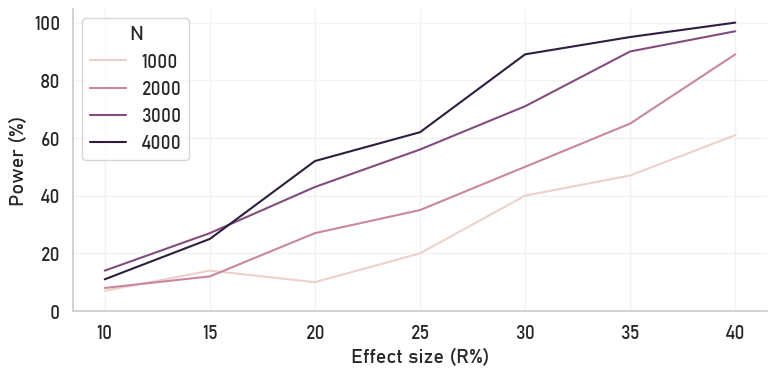

In [5]:
sns.set_theme(style='whitegrid', font='Bahnschrift', font_scale=1.2)
sns.set_style({"grid.color": ".95"})

fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(x='effect_size', y='1', hue='N', data=beta[beta['N'].isin([1000,2000,3000,4000])], legend='full', ax=ax)
ax.set_xlabel('Effect size (R%)')
ax.set_ylabel('Power (%)')
ax.set_ylim((0))
sns.despine()
plt.tight_layout()
plt.savefig('./plots/effectsize_vs_power_col.png', dpi=300)

Grayscale version.

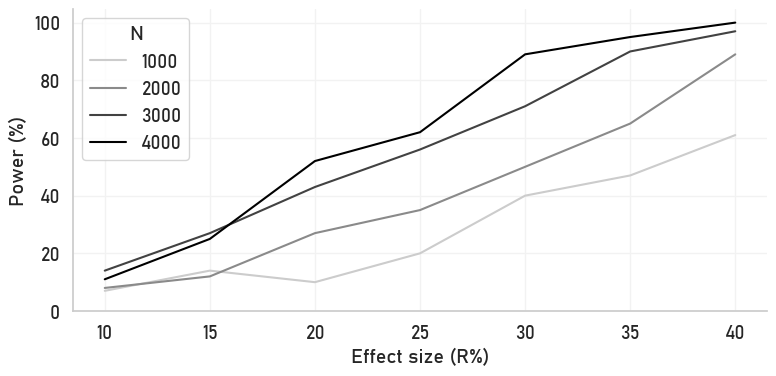

In [6]:
sns.set_theme(style='whitegrid', font='Bahnschrift', font_scale=1.2)
sns.set_style({"grid.color": ".95"})

fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(x='effect_size', y='1', hue='N', data=beta[beta['N'].isin([1000,2000,3000,4000])], palette=['0.8','0.54','0.26','0.00'], legend='full', ax=ax)
ax.set_xlabel('Effect size (R%)')
ax.set_ylabel('Power (%)')
ax.set_ylim((0))
sns.despine()
plt.tight_layout()
plt.savefig('./plots/effectsize_vs_power_bw.png', dpi=300)

## Example run

Plotting an example run as used in power analysis experiments - create synthetic data, then apply the shuffle method to it.

Rates are set to match the empirical data, so first read this.

In [7]:
data = pd.read_excel("A:/UCLMaster_V2.xlsx", sheet_name=1, index_col='URN')

# Count how many valid values for each time period
data['ValidPre'] = data.loc[:,'Pre48':'Pre1'].count(axis=1)
data['ValidDur'] = data.loc[:,'Dur1':'Dur63'].count(axis=1)
data['ValidPost'] = data.loc[:,'Post1':'Post48'].count(axis=1)
data['ValidAll'] = data.loc[:,'Pre48':'Post48'].count(axis=1)

# Fill missing values of PostMths with zeros
data['PostMths'] = data['PostMths'].fillna(0)
data['PreDurMths'] = data['PreMths'] + data['DuringMths']

# Note the first valid month in the data, measured from 10th birthday
# Month columns are measured SINCE this - first valid PreXX is 0 months after StartMth
data['StartMth'] = data['PreMths'] - data['ValidPre']

# EndMth will be one after the last valid month in the data (i.e. the next missing month)
data['EndMth'] = data['StartMth'] + data['ValidAll']

histories_raw = data.loc[:, 'Pre48': 'Post48'].T

# Set up a dictionary to record each individual's history
histories_continuous = {}
for urn in histories_raw:
    #For each column, drop missing values
    history = histories_raw[urn].dropna()
    #Re-set the index so it corresponds to the individual's age
    history.index = np.arange(data.loc[urn,'StartMth'], data.loc[urn,'EndMth'])
    histories_continuous[urn] = history
# Store these histories as a DataFrame
histories = pd.DataFrame(histories_continuous)

# Calculate sanction rates and entry points
sanction_rates = histories.mean(axis=1)
entry_points = data['PreMths']

Simulate sanction data for a hypothetical population and perform shuffle algorithm.

In [8]:
# Parameters for data simulation
n_people = 3000
treatment_factor = 0.8
n_perm = 99

# Simulate the synthetic entry points and offending histories
entry_points_synth = synth.sample_entry_points(entry_points, n_people, seed=12)
histories_synth = synth.simulate_histories(sanction_rates, n_people, treatment_factor, entry_points_synth, seed=34)

# Align the histories and calculate sanction rates
histories_aligned = shuffle.align_data_buff(histories_synth, entry_points_synth, 24, 24)
observed_rates = histories_aligned.mean(axis=1) * 100

# Apply permutation test to the synthetic data
perm_rates = shuffle.permuted_rates(histories_synth, entry_points_synth, 24, 24, n_perm)

Plot the observed rates and rates under shuffling.

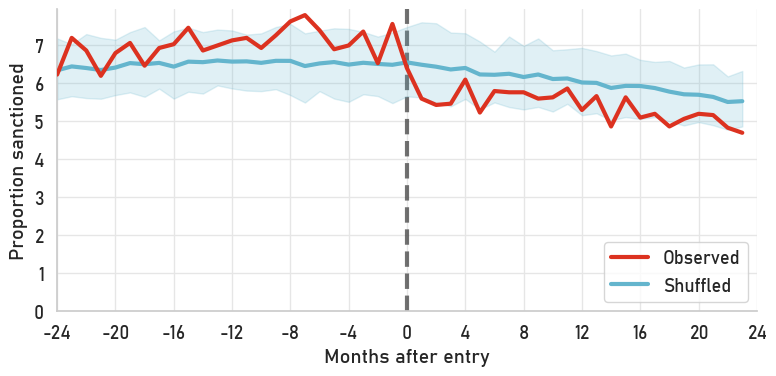

In [9]:
# Aesthetic settings
sns.set_style({"grid.color": ".9"})

# Multiply rates by 100 to express as percentages
perm_percs = perm_rates * 100
# Calculate the mean across all shuffles
perm_mean = perm_percs.mean(axis=0)
perm_std = perm_percs.std()
perm_sem = perm_percs.sem()
# ...and the quantiles
quantiles = perm_percs.quantile([0.025, 0.975])

# Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

#Plot the observed rates and the mean shuffled rates as lines
observed_rates.plot(label='Observed', color='#DC3220', lw=3, zorder=3, ax=ax)
perm_mean.plot(xlim=(-24,23), c='c', lw=3, label='Shuffled', zorder=2, ax=ax)

#Plot a tube representing the quantiles
ax.fill_between(perm_mean.index, quantiles.loc[0.025, :], quantiles.loc[0.975, :], color='c', alpha=0.2, zorder=1.5)

# Add legend and line to represent entry point
plt.legend(loc='lower right')
ax.axvline(0, color ='0.3', ls='--', lw=3, alpha=0.8, zorder=1)

# Set limits and ticks
ax.set_ylim(0)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned')

# Tidy up figure and save
sns.despine()
plt.tight_layout()
plt.savefig('./plots/synthetic_run_example_col.png', dpi=300)

Grayscale version.

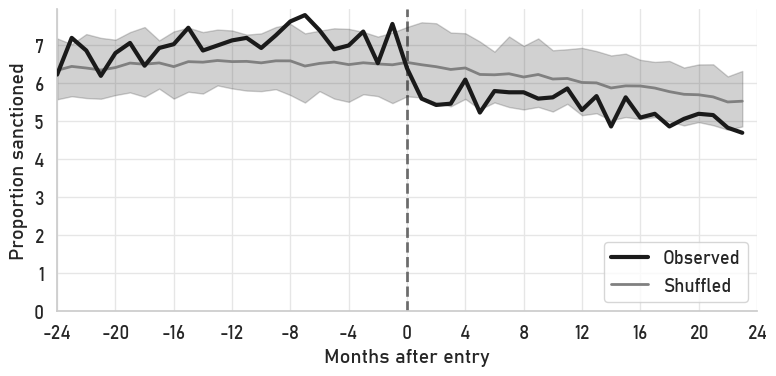

In [10]:
# Aesthetic settings
sns.set_style({"grid.color": ".9"})

# Multiply rates by 100 to express as percentages
perm_percs = perm_rates * 100
# Calculate the mean across all shuffles
perm_mean = perm_percs.mean(axis=0)
perm_std = perm_percs.std()
perm_sem = perm_percs.sem()
# ...and the quantiles
quantiles = perm_percs.quantile([0.025, 0.975])

# Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

#Plot the observed rates and the mean shuffled rates as lines
observed_rates.plot(label='Observed', color='k', lw=3, zorder=3, ax=ax)
perm_mean.plot(xlim=(-24,23), c='0.5', lw=2, label='Shuffled', zorder=2, ax=ax)

#Plot a tube representing the quantiles
ax.fill_between(perm_mean.index, quantiles.loc[0.025, :], quantiles.loc[0.975, :], color='k', alpha=0.2, zorder=1.5)

# Add legend and line to represent entry point
plt.legend(loc='lower right')
ax.axvline(0, color ='0.3', ls='--', lw=2, alpha=0.8, zorder=1)

# Set limits and ticks
ax.set_ylim(0)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned')

# Tidy up figure and save
sns.despine()
plt.tight_layout()
plt.savefig('./plots/synthetic_run_example_bw.png', dpi=300)